In [12]:
!pip install eep153_tools --upgrade
!pip install python-gnupg
!pip install eep153_tools
%pip install cfedemands

import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets



Note: you may need to restart the kernel to use updated packages.


In [13]:
Guatemala_Data = '1JywFwg0TLswsumYX932nagHF1rgsvvzeIUXZwhmzJ6s'

In [14]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

x = read_sheets(Guatemala_Data,sheet='Food Expenditures (2000)')
x = x.set_index(['i','t','m','j']).squeeze()


# Now prices
p = read_sheets(Guatemala_Data,sheet='Food Prices (2000)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(Guatemala_Data,sheet="Household Characteristics")
d.columns.name = 'k'

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)

d.set_index(['i','t','m'],inplace=True)

In [15]:
from cfe import Regression

result = Regression(y=y,d=d)

In [16]:
result.predicted_expenditures()

i     t     m              j             
1     2000  Metropolitana  Avocado             7.088698
                           Bananas            16.067197
                           Beans               9.494430
                           Beef              100.138098
                           Beef Entrails      13.948086
                                                ...    
7276  2000  Suroriente     Tostadas            9.664286
                           Water (bottle)     11.366774
                           Watermelon          7.872758
                           Wheat Flour         4.710398
                           Yucca               3.394201
Length: 515736, dtype: float64

<Axes: xlabel='yhat', ylabel='y'>

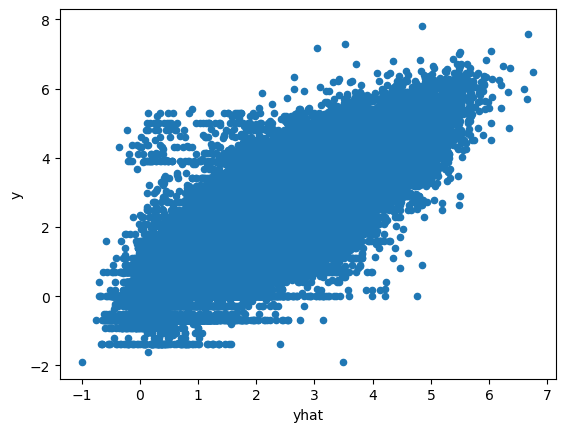

In [17]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

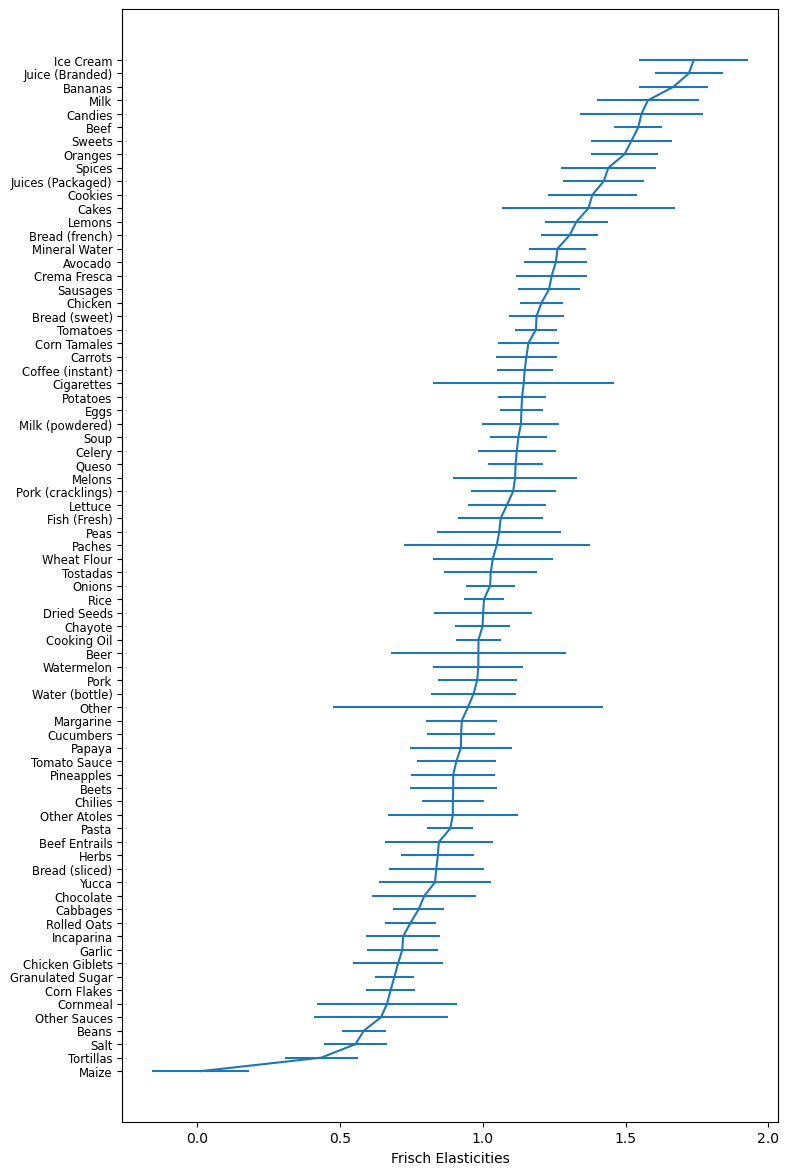

In [18]:
ax = result.graph_beta()

In [70]:
beta = result.get_beta()

In [86]:
##DELIERABLE COUNTERFACTUAL
beta_df = beta.reset_index()
beta_df.columns = ['Food', 'Beta']

beta_df_sorted = beta_df.sort_values(by='Beta', ascending=True)
beta_df_sorted

,Food,Beta
41,Maize,0.013067
70,Tortillas,0.434879
63,Salt,0.554703
2,Beans,0.584281
51,Other Sauces,0.644436
...,...,...
12,Candies,1.555973
44,Milk,1.578322
1,Bananas,1.667667
37,Juice (Branded),1.721491


In [82]:
##This table ranks food items by their expenditure elasticity (β), showing how sensitive spending is to changes in total food budget. 
##Maize, tortillas, and beans have the lowest betas, meaning they are necessities—households buy them regardless of income. 
##In contrast, items like ice cream and branded juice have the highest betas, classifying them as luxury goods whose demand rises sharply with increased spending.

In [85]:
# Get the beta for maize
maize_beta = beta_df.loc[beta_df['Food'] == 'Maize', 'Beta'].values[0]

# Simulate a 200% price increase → price becomes 3x → log change is log(3)
price_increase_log = np.log(3)

# Estimate log change in expenditure using elasticity approximation
# Δlog(E) ≈ β * Δlog(Total Expenditure), but in our case, we simulate the price effect on its own
# Since maize is essential, we assume quantity doesn't drop much, so:
# Expenditure change ≈ price change (for inelastic goods)

# Simulate % change in expenditure (linearized)
expenditure_change_percent = price_increase_log * 100  # ≈ 109.86%

print(f"Simulated expenditure increase on maize (log price ↑200%): ≈ {expenditure_change_percent:.2f}%")
print(f"Because β for maize is very low ({maize_beta:.5f}), the demand is still highly inelastic.")


Simulated expenditure increase on maize (log price ↑200%): ≈ 109.86%
Because β for maize is very low (0.01307), the demand is still highly inelastic.
